# 10718 Assignment 1: Getting to know the class project

## Overview

The purpose of this exercise is to provide a quick introduction to the data and modeling problem we'll be using as an illustrative example throughout Machine Learning in Practice (10-718). Note that this colab notebook **only uses a small sample of the data**, but we'll be working with the full dataset as you get into your group projects for the rest of the semester.

**Completing this assignment should only take you 2-3 hours.**

## Problem Background

This notebook makes use of a sample of the data provided by [DonorsChoose](https://www.donorschoose.org/) to the [2014 KDD Cup](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data). Public schools in the United States face large disparities in funding, often resulting in teachers and staff members filling these gaps by purchasing classroom supplies out of their own pockets. DonorsChoose is an online crowdfunding platform that tries to help alleviate this financial burden on teachers by allowing them to seek funding for projects and resources from the community (projects can include classroom basics like books and markers, larger items like lab equipment or musical instruments, specific experiences like field trips or guest speakers).

Projects on DonorsChoose expire after 4 months, and if the target funding level isn't reached, the project receives no funding. Since its launch in 2000, the platform has helped fund over 2 million projects at schools across the US, but about 1/3 of the projects that are posted nevertheless fail to meet their goal and go unfunded.

### The Modeling Problem

For the purposes of this exercise, let's assume that DonorsChoose has hired a digital content expert who will review projects and help teachers improve their postings and increase their chances of reaching their funding threshold. Because this individualized review is a labor-intensive process, the digital content expert has ** time to review and support only 10% of the projects posted to the platform on a given day**.

You are a data scientist working with DonorsChoose, and your task is to help this content expert focus their limited resources on projects that most need the help. As such, you want to build a model to **identify projects that are least likely to be fully funded before they expire**  and pass them off to the digital content expert for review.


# Getting Set Up

Running the code below will create a local postgres 11 database for you and import the sampled donors choose data. Don't worry about the details of that and you shouldn't need to touch any of the code here aside from running it. Below, we'll talk about how to access the database from within the notebook to run queries.

In [ ]:
# Install and start postgresql-11 server
!sudo apt-get -y -qq update
!wget --quiet -O - https://www.postgresql.org/media/keys/ACCC4CF8.asc | sudo apt-key add -
!echo "deb http://apt.postgresql.org/pub/repos/apt/ `lsb_release -cs`-pgdg main" |sudo tee  /etc/apt/sources.list.d/pgdg.list
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql-11 postgresql-client-11
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"

# Setup a database with name `donors_choose` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS donors_choose;'

!sudo -u postgres psql -U postgres -c 'CREATE DATABASE donors_choose;'

# Environment variables for connecting to the database
%env DEMO_DATABASE_NAME=donors_choose
%env DEMO_DATABASE_HOST=localhost
%env DEMO_DATABASE_PORT=5432
%env DEMO_DATABASE_USER=postgres
%env DEMO_DATABASE_PASS=postgres

OK
deb http://apt.postgresql.org/pub/repos/apt/ jammy-pgdg main
W: http://apt.postgresql.org/pub/repos/apt/dists/jammy-pgdg/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 12.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libjson-perl.
(Reading database ... 120893 files and directories currently installed.)
Preparing to unpack .../00-libjson-perl_4.04000-1_all.deb ...
Unpacking libjson-perl (4.04000-1) ...
Selecting previously unselected package netbase.
Preparing to un

In [ ]:
# Download sampled DonorsChoose data and load it into our postgres server
!curl -s -OL https://dsapp-public-data-migrated.s3.us-west-2.amazonaws.com/donors_sampled_20210920_v3.dmp
!PGPASSWORD=$DEMO_DATABASE_PASS pg_restore -h $DEMO_DATABASE_HOST -p $DEMO_DATABASE_PORT -d $DEMO_DATABASE_NAME -U $DEMO_DATABASE_USER -O -j 8 donors_sampled_20210920_v3.dmp

In [ ]:
!pip install SQLAlchemy==1.3.18 PyYAML==6.0 psycopg2-binary==2.9.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.0 MB/s eta 0:00:00
  Created wheel for SQLAlchemy: filename=SQLAlchemy-1.3.18-cp310-cp310-linux_x86_64.whl size=1236053 sha256=23993047e97c5a14399d2c553b4ab6e252eae7f0f1e6ae10ffd67289437156ad
  Stored in directory: /root/.cache/pip/wheels/c2/ce/f0/920f24badb829d2c35ec186a9646618cb7bbb5cbcfad7441a2
Successfully built SQLAlchemy
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.20
    Uninstalling SQLAlchemy-2.0.20:
      Successfully uninstalled SQLAlchemy-2.0.20
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0.1
    Uninstalling PyYAML-6.0.1:
      Successfully uninstalled PyYAML-6.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages 

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [ ]:
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine

db_url = URL(
            'postgres',
            host='localhost',
            username='postgres',
            database='donors_choose',
            password='postgres',
            port=5432,
        )

db_engine = create_engine(db_url)

# Querying the Database

The code block above used the `sqlalchemy` module to create a connection to the database called `db_engine`. An easy way to run SQL queries against this database is to use the `read_sql` command provided by `pandas`. For instance, if you run the example below, it should return the number of projects in the sampled dataset (16,480):

In [ ]:
pd.read_sql("SELECT COUNT(*) FROM data.projects", db_engine)

,count
0,16480


You can find some more details about the dataset on the [KDD Cup page](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data), but here is a quick description of the four main source tables:
- `data.projects` contains information about each project that was posted on the site, including IDs for the project, school, and teacher, as well as the total amount being requested (note that projects can also request additional "optional support" but don't need to reach this higher bar to be funded)
- `data.essays` has project titles and descriptions
- `data.resources` has information about the specific resources being requested
- `data.donations` contains details about each donation that was received by a project (when it came in, the amount, whether it was from another teacher, etc.)

** Note that if you prefer to work in python to explore and manipulate the data, you can download a full table (for example, `data.projects`) into a pandas dataframe via**:
```
projects_df = pd.read_sql("SELECT * FROM data.projects", db_engine)
```

## Want other packages?
If you need to install any other python modules for your analysis, you can easily do so from a code block by prefixing your `pip install` command with an `!` character. For instance:
```
!pip install PyYAML
```

# QUESTION 1

**(A)** Create a scatter plot of the number of resources requested vs fraction of the total ask amount that was funded across all projects in New Hampshire. (Hint: You'll need to join a couple of tables here to figure out the amount donated to a project)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

projects_df = pd.read_sql("SELECT * FROM data.projects WHERE school_state='NH'", db_engine)
project_ids = projects_df['projectid_str']

In [ ]:
resources_df = pd.read_sql("SELECT * FROM data.resources", db_engine)
donations_df = pd.read_sql("SELECT * FROM data.donations", db_engine)

num_resources = []
for proj in project_ids:
   proj_df = resources_df[resources_df['projectid_str']==proj]
   resources = len(proj_df['resourceid'])
   num_resources.append(resources)


In [ ]:
asking_price = pd.read_sql("SELECT projectid_str, total_asking_price FROM data.projects", db_engine)
donation_price = pd.read_sql("SELECT projectid_str, donation_to_project FROM data.donations", db_engine)
merged = pd.merge(asking_price, donation_price, on='projectid_str', how='outer')
merged.fillna(0, inplace=True)


In [ ]:
fund_ratio = []
for proj in project_ids:
  proj_df = merged[merged['projectid_str'] == proj]
  ask = proj_df['total_asking_price'].sum()
  donate = proj_df['donation_to_project'].sum()
  fund_ratio.append(donate/ask)



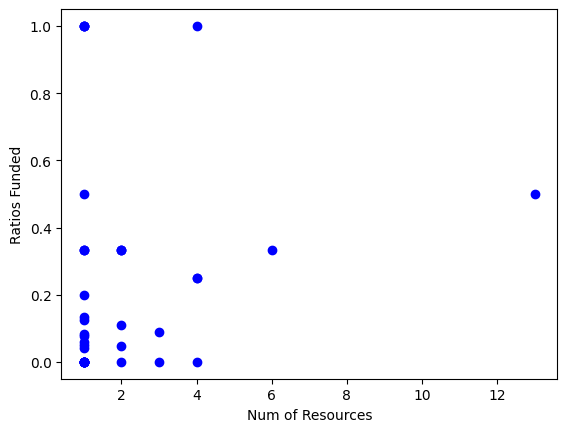

In [ ]:
plt.scatter(num_resources, fund_ratio, label='Scatterplot', color='blue', marker='o')
plt.xlabel("Num of Resources")
plt.ylabel("Ratios Funded")
plt.show()

**(B)** Spend a little time exploring the data, with a focus on the outcome of whether or not a project is fully funded after 4 months as well as features you think might be predictive of this outcome.

In [ ]:
projects_df['date_posted']

0    2012-12-20
1    2010-09-18
2    2013-11-15
3    2008-03-10
4    2008-11-28
5    2009-05-04
6    2009-06-12
7    2009-06-12
8    2009-06-14
9    2009-06-22
10   2009-06-30
11   2009-08-22
12   2009-11-01
13   2009-11-02
14   2010-02-05
15   2010-02-14
16   2010-02-28
17   2010-04-01
18   2010-06-27
19   2010-07-16
20   2010-09-26
21   2010-09-30
22   2010-11-23
23   2011-01-02
24   2011-02-18
25   2011-02-18
26   2011-03-13
27   2011-04-09
28   2011-08-21
29   2011-08-21
30   2011-08-21
31   2013-07-16
32   2013-07-19
33   2013-11-05
34   2013-11-30
35   2013-12-08
36   2013-12-31
37   2014-01-01
38   2014-05-10
Name: date_posted, dtype: datetime64[ns]

In [ ]:
donations_df

,donationid,projectid_str,donor_acctid,donor_city,donor_state,donor_zip,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,dollar_amount,donation_included_optional_support,payment_method,payment_included_acct_creadit,payment_included_campaign_gift_card,payment_included_web_purchased_gift_card,payment_was_promo_matched,via_giving_page,for_honoree,donation_message,entity_id
0,705ef855c2d90eed594cf26e634add93,fb9d9bebbd2309cbd948a03c00ec65b0,112631d2731d90f8ac0ae542d67904fe,,None,None,False,2009-11-09 10:49:34.648,41.00,9.00,50.00,10_to_100,True,no_cash_received,False,True,False,False,False,False,None,495172
1,59b71f584f3516f75d4e98d8acbaa65f,f93456e60338550f3ad7a2a0e87617dd,127936d3a07b33d3012bb23a9464532a,Austin,TX,78704,False,2011-09-02 08:48:01.447,85.00,15.00,100.00,100_and_up,True,paypal,False,False,False,False,True,False,None,336273
2,8bcc055f586e0343dd8779fdd8ac4775,f7848f096af41049e8dc6af81139d2b6,55223d1a24127d2fcce3a0b45e917b03,Chicago,IL,60093,False,2013-12-01 09:49:55.145,17.00,3.00,20.00,10_to_100,True,amazon,False,False,False,False,False,False,None,99049
3,3afbbc4257049362dab620251c49a4a0,f3d5ec1500fe57584856d4cce2d66161,88c6f8743b0340853b548404f8de9e5b,None,PR,None,False,2013-05-13 09:41:48.006,4.25,0.75,5.00,under_10,True,no_cash_received,False,True,False,False,False,False,Cause,173719
4,acf6e26e501def0b285834026459e592,f33b72a6093a64696d3a8e7ef2d0afa7,85e51d426e69e46b785b0225117b7e8b,None,None,None,True,2011-01-11 18:58:57.280,8.50,1.50,10.00,10_to_100,True,creditcard,False,False,False,False,True,False,None,395246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68949,966be3d8a09450946186a0f808ff27f0,fff2173cd82bd5bfd255a33018cdf87e,55ea16e9efe339ed11a8ee78fd97704c,,None,None,False,2008-11-21 20:13:23.106,7.50,2.50,10.00,10_to_100,True,no_cash_received,False,True,False,False,False,False,I gave to this project because...this is in my...,555868
68950,7037d9550aee1bac99102e96d34b3df2,fff2173cd82bd5bfd255a33018cdf87e,3e908ffff654f2363dfd6cc42c04a797,CLIFTON,NJ,07012,False,2009-01-15 11:48:52.388,7.50,2.50,10.00,10_to_100,True,no_cash_received,False,True,False,False,False,False,None,555868
68951,336b26182fcbbbc3003ad9af87226395,fff2173cd82bd5bfd255a33018cdf87e,81728d858349736bd17eee6e38d73b84,egg harbor twp,NJ,08234,False,2009-01-15 11:48:52.438,26.75,8.92,35.67,10_to_100,True,no_cash_received,False,True,False,False,False,False,None,555868
68952,e8c92b166649bc7bbcf8ace4b09558c1,fffc3632fd681fde1113eae31ca027d4,22df8a7bf0b7332022fce950da70daba,None,None,None,False,2012-12-10 09:39:30.486,8.50,1.50,10.00,10_to_100,True,no_cash_received,False,True,False,False,False,False,I donated because I want to support kids in Te...,195612


In [ ]:
#POVERTY LEVEL FEATURES
print(len(projects_df[projects_df['poverty_level']=='low poverty']))
print(len(projects_df[projects_df['poverty_level']=='moderate poverty']))

2
37


In [ ]:
#no private schools, all publically funded so not important feature
projects_df['school_charter']

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
Name: school_charter, dtype: bool

In [ ]:
projects_df['date_posted']

0    2012-12-20
1    2010-09-18
2    2013-11-15
3    2008-03-10
4    2008-11-28
5    2009-05-04
6    2009-06-12
7    2009-06-12
8    2009-06-14
9    2009-06-22
10   2009-06-30
11   2009-08-22
12   2009-11-01
13   2009-11-02
14   2010-02-05
15   2010-02-14
16   2010-02-28
17   2010-04-01
18   2010-06-27
19   2010-07-16
20   2010-09-26
21   2010-09-30
22   2010-11-23
23   2011-01-02
24   2011-02-18
25   2011-02-18
26   2011-03-13
27   2011-04-09
28   2011-08-21
29   2011-08-21
30   2011-08-21
31   2013-07-16
32   2013-07-19
33   2013-11-05
34   2013-11-30
35   2013-12-08
36   2013-12-31
37   2014-01-01
38   2014-05-10
Name: date_posted, dtype: datetime64[ns]

In [ ]:
#number of students impacted by funded project
projects_df['students_reached']

0      18
1     120
2      95
3      85
4      90
5      90
6     100
7      85
8      90
9      85
10    200
11    250
12    400
13    240
14    300
15    300
16    400
17     85
18    270
19     85
20     85
21     85
22    100
23    300
24    240
25    240
26     85
27     85
28    125
29    125
30    125
31    230
32    230
33    240
34    230
35    230
36    230
37     95
38    260
Name: students_reached, dtype: int64

In [ ]:
projects_df['resource_type']

0     Technology
1     Technology
2     Technology
3     Technology
4     Technology
5       Supplies
6          Books
7       Supplies
8          Books
9          Books
10    Technology
11    Technology
12      Supplies
13      Supplies
14    Technology
15    Technology
16      Supplies
17    Technology
18      Supplies
19      Supplies
20    Technology
21    Technology
22      Supplies
23         Other
24    Technology
25    Technology
26      Supplies
27      Supplies
28    Technology
29      Supplies
30    Technology
31    Technology
32    Technology
33    Technology
34    Technology
35    Technology
36    Technology
37    Technology
38    Technology
Name: resource_type, dtype: object

# QUESTION 2

For this question, you'll develop a model to help DonorsChoose **identify 10% of projects with the highest risk of failing to meet their funding goal** for their digital content expert review and provide suggestions. In order to intervene early in the process, DonorsChoose wants to identify these projects to help **immediately upon being posted** to the site.

Build and evaluate the performance of several machine learning models for this task. **Be sure to use comments or text blocks to discuss the choices and assumptions you're making along the way.** Feel free to use any python packages available (such as sklearn) for this.

To identify the 10% of projects with highest risk of failing to meet funding goal, I choose the following features as being predictive of this outcome:
1. project resource category
2. project cost
3. number of resources requested
4. poverty level

In [ ]:
#Data preprocessing to help collect groundtruth/training/test data
projects_df = pd.read_sql("SELECT * FROM data.projects", db_engine)
project_ids = projects_df['projectid_str']

resources_df = pd.read_sql("SELECT * FROM data.resources", db_engine)
donations_df = pd.read_sql("SELECT * FROM data.donations", db_engine)

num_resources = []
for proj in project_ids[:5000]:
   proj_df = resources_df[resources_df['projectid_str']==proj]
   resources = len(proj_df['resourceid'])
   num_resources.append(resources)

asking_price = pd.read_sql("SELECT projectid_str, total_asking_price FROM data.projects", db_engine)
donation_price = pd.read_sql("SELECT projectid_str, donation_to_project FROM data.donations", db_engine)
merged = pd.merge(asking_price, donation_price, on='projectid_str', how='outer')
merged.fillna(0, inplace=True)

fund_ratio = []
for proj in project_ids[:5000]:
  proj_df = merged[merged['projectid_str'] == proj]
  ask = proj_df['total_asking_price'].sum()
  donate = proj_df['donation_to_project'].sum()
  fund_ratio.append(donate/ask)



<ipython-input-330-a9dba99507c6>:24: RuntimeWarning: invalid value encountered in double_scalars
  fund_ratio.append(donate/ask)


In [ ]:
#use ratios to determine whether funding goals have been met or not
# treat as binary classification problem
funded = []
notfunded = []
for i in range(len(fund_ratio)):
    if fund_ratio[i] ==1.0:
      funded.append(project_ids[i])
    else:
      notfunded.append(project_ids[i])


In [ ]:
#fully funded projects get value of 0, for binary classification
funded_df = projects_df[projects_df['projectid_str'].isin(funded)]
funded_df['funded'] = 0

<ipython-input-332-7e5b413e4e07>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funded_df['funded'] = 0


In [ ]:
#projects that don't meet funding goal get value of 1
notfunded_df = projects_df[projects_df['projectid_str'].isin(notfunded)]
notfunded_df['funded'] = 1

<ipython-input-333-ffa1c5745f48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notfunded_df['funded'] = 1


In [ ]:
#combine into single dataset for training/testing
data_df = pd.concat([notfunded_df, funded_df], axis=0)

In [ ]:
#feature selection for logistic regression
selected_columns = ['school_metro', 'primary_focus_area', 'resource_type', 'poverty_level', 'total_asking_price']
X = data_df[selected_columns]
y = data_df['funded']

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
#encode categorial variables as integers
label_encoder = LabelEncoder()
for feat in selected_columns:
  X[feat] = label_encoder.fit_transform(X[feat])

<ipython-input-337-9d2731b1ff65>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feat] = label_encoder.fit_transform(X[feat])
<ipython-input-337-9d2731b1ff65>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feat] = label_encoder.fit_transform(X[feat])
<ipython-input-337-9d2731b1ff65>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [ ]:
#split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
###LOGISTIC REGRESSION MODEL

In [ ]:
# Create the logistic regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = model.predict(X_test)


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.88


In [ ]:
###SVM MODEL

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [ ]:
clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.88


# QUESTION 3

Briefly discuss (in at most 1-2 paragraphs) the results of your analysis above: Which model would you select to deploy and why? Are there future analysis or improvements you would suggest? Are there other data sources you would ideally like to be able to incorporate into your models?

I tested two models: a logistic regression model and an SVM classifier. Both models seem to perform at the same accuracy and I believe this is due to and inbalance in the dataset, in which most of the projects don't reach their funding goals so the model can predict in this binary setting and have high accuracy but low precision. In future iterations of this project, I would like to do a deeper analysis into which features of the data in a logistic regression model are most informative as to whether a project needs more help to reach its goals. This will be crucial in determining which 10% of projects need additional help to meet their funding goals. Feature selection will be crucial in the success of future iterations of the model. Additionally, more steps will need to be taken in data preprocessing if I make this a binary classification task to prevent bias towards either target.

# Submission

To submit your exercise, please **save a copy** of this notebook containing your code and outputs (you can save it either to google drive or github, but make sure the course staff will have read permissions to access it).

Provide a link to your copy of the notebook when you submit the assignment in canvas.

Thank you and we're looking forward to a great semester in 10718!